In [34]:
import math
import scipy
import numpy as np
import pandas as pd
import math as m
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

from scipy.spatial import distance_matrix
from scipy import linalg
from scipy.optimize import minimize
from scipy.linalg import eig, eigh
from scipy.fft import fft
from scipy.special import eval_gegenbauer, sph_harm

from sklearn.datasets import make_swiss_roll
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from sklearn.decomposition import KernelPCA, PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors

#import scaleogram as scg
import matplotlib.pyplot as plt
import warnings

from tqdm.notebook import tqdm

from visuals import *
from my_lib import *
from SSA_lib import SSA

In [2]:
warnings.simplefilter('ignore')

# plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = 15, 5
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

In [3]:
def CartesianToSpherical(point):
    r = np.sqrt(sum(point ** 2))
    n = len(point)
    phi = np.zeros(n - 1)
    
    for i in range(n - 2):
        phi[i] = np.arccos(point[i] / np.sqrt(sum(point[i:] ** 2)))
        
    if point[-1] >= 0:
        phi[n - 2] = np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
    else:
        phi[n - 2] = 2 * np.pi - np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
        
    return np.hstack((phi, r))


def TrajectoryToSpherical(tr):
    tr_spherical = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_spherical[i] = CartesianToSpherical(point)
    return tr_spherical


def SphericalToCartesian(point):
    phi, r = point[:-1], point[-1]
    n = len(point)
    x = np.zeros(n) 
    cur = r
    
    for i in range(n - 1):
        x[i] = cur * np.cos(phi[i])
        cur *= np.sin(phi[i])

    x[n - 1] = cur
    return x
    
def TrajectoryToCartesian(tr):
    tr_cartesian = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_cartesian[i] = SphericalToCartesian(point)
    return tr_cartesian

def HankelMatrix(X, L):  
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])

In [28]:
dt = 450 * 20
data = pd.read_csv('data/long_walk_100_acc.csv', delimiter =';', decimal=',')[7101:7101+dt]

frequency = len(data)/(data['time'].values[-1]-data['time'].values[0])

assert 490 < frequency < 510, f'Bad frequency {frequency}'
print(f'Frequency {frequency}')

x_acc = ( (data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5
_m = np.mean(x_acc)
_std = (sum((x_acc - _m)**2)/len(x_acc))**.5

x_acc = (x_acc-_m)

t = (data['time'].values).astype(float).reshape([-1,])
t = np.linspace(0,t[-1]-t[0],len(x_acc))

fig = go.Figure()
fig.add_scatter(y = x_acc, mode='lines', name='Sum squares')
fig.show()

Frequency 500.10835681064236


# Linear PCA

In [36]:
lin_pca = []
for time_delay in tqdm(np.arange(200,901,10)):
    X = HankelMatrix(x_acc, time_delay)
    pca_ = PCA(n_components = 1)
    pca_.fit(X[:5000,:])
    X_PCA = pca_.transform(X[5000:,:])
    X_reconstruct = pca_.inverse_transform(X_PCA)
    
#     plt.plot(X[:,0])
#     plt.plot(X_reconstruct[:,0],".")
#     plt.show()
    
#     plt.plot(X_PCA,".")
#     plt.show()
    
    lin_pca.append([ r2_score(X_reconstruct,X[5000:,:]), time_delay])
lin_pca = np.array(lin_pca)

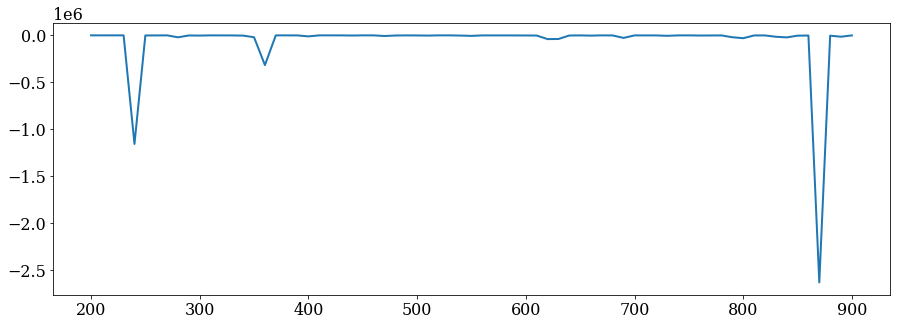

In [37]:
plt.plot(lin_pca[:,1],lin_pca[:,0])

# Kernel PCA

In [ ]:
for dim in range(1,50):
    pca_ = PCA(n_components = dim)
    X_PCA = pca_.fit_transform(X)
    X_reconstruct = pca_.inverse_transform(X_PCA)
    
    Comp_DF.loc[dim-1,'PCA'] = mean_squared_error(X_reconstruct,X)

In [ ]:
Comp_DF.plot()